## What does an objective function look like ?

First, we import the necessary dependencies...

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import scipy
from scipy.optimize import curve_fit

# We fix the random seed to always get the same problem

np.random.seed(seed=42)

# A simple problem : A straigh line fitting

We will fit a first order polynomial function. So the forward model is:

In [2]:
def forward_model(x,a,b):
    return a + x*b

Let's generate fake data. We will add outliers in the data, two anormal points. Maybe the apparatus had a bug, maybe the operator was sleeping...

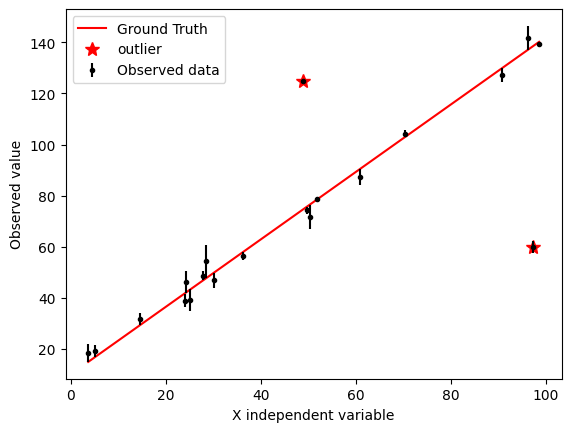

In [6]:
# true parameters
a = 10.0
b = 1.321

N = 20

x = np.sort(100*np.random.rand(N))
y = forward_model(x,a,b)

# Real world observations are noisy...
# we have random errors there, no systematic bias
ese = 3*np.random.randn(N)

y_observed = y + ese

y_observed[10] = 125
y_observed[18] = 60

plt.figure()
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x[[10,18]],y_observed[[10,18]],"r*",ms=10,label="outlier")
plt.errorbar(x,y_observed,yerr=abs(ese),fmt='.',color="k",label="Observed data")

#plt.plot(x,y,"r-",label="Ground Truth")
plt.xlabel("X independent variable")
plt.ylabel("Observed value")
plt.legend(loc=2)

We see that the outliers are very far from the general trend. What happens if we use `curve_fit` on this dataset?

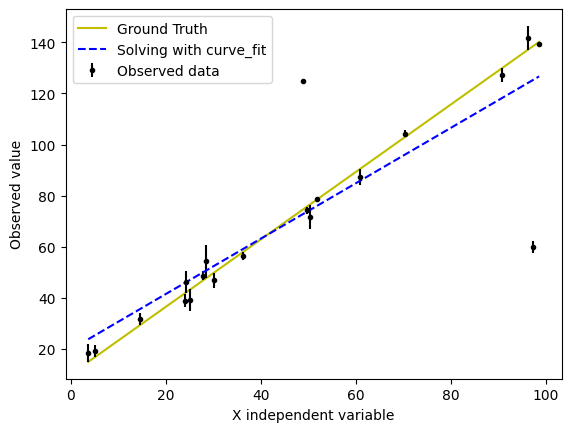

In [9]:
from scipy.optimize import minimize
popt, pcov = curve_fit(forward_model, x, y_observed )

plt.figure()
plt.plot(x,y,"y-",label="Ground Truth")
plt.errorbar(x,y_observed,yerr=abs(ese),fmt='.',color="k",label="Observed data")
plt.plot(x,forward_model(x, *popt),"b--",label="Solving with curve_fit")

#plt.plot(x,y,"r-",label="Ground Truth")
plt.xlabel("X independent variable")
plt.ylabel("Observed value")
plt.legend(loc=2)

Hum, it seems that the regression is heavily influenced by the outliers. This is because the least square (LS) criterion:

$misfit = \sum_{i=1}^{n}{(d_i-m_i)^2}$ , eq. 1 

is not the best when dealing with data containing outliers. In this case, we can adopt a different mistfit function, the least absolute deviation (LAD)criterion: 

$misfit = \sum_{i=1}^{n}{|(d_i-m_i)|}$ . eq. 2

Let's perform a fit with the latter one. To do so, we cannot use `curve_fit` because it utilizes the LS criterion under the hood.
We need to use a lower level interface, namely scipy.optimize.minimize, to define our own mistfit function and us it. Let's do that !

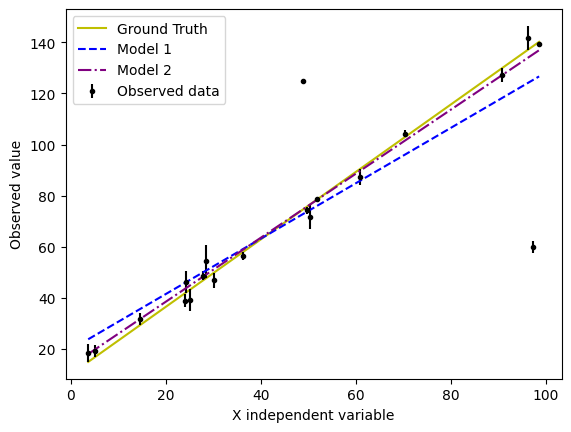

In [12]:
def least_absolute_deviation(y_observed,y_calculated):
    """this is my LAD misfit function, a simple sum of the basolute deviations between data and predictions"""
    return np.sum(np.abs(y_observed-y_calculated))

def objective_function(p, x, y):
    """this is the objective function, that contains all the required calculations to get a single value of misfit"""
    y_calc = forward_model(x, *p)
    misfit = least_absolute_deviation(y, y_calc)
    return misfit

# we import the necessary algorithm
from scipy.optimize import minimize
# minimize do not work like curve_fit, we provide an entier objective function, starting parameters values in a list, and x and y values in argument.
resultat = minimize(objective_function, [0,0], method="Nelder-Mead", args=(x, y_observed))

# "resultat" is an dictionnary, its attribute "x" contains the best values after adjustment
popt2 = resultat["x"]

# we now plot the results and observe the differences with curve_fit.
plt.figure()
plt.plot(x,y,"y-",label="Ground Truth")
plt.errorbar(x,y_observed,yerr=abs(ese),fmt='.',color="k",label="Observed data")
plt.plot(x,forward_model(x, *popt),"b--",label="Model 1")
plt.plot(x,forward_model(x, *popt2),"-.",c="purple", label="Model 2")

#plt.plot(x,y,"r-",label="Ground Truth")
plt.xlabel("X independent variable")
plt.ylabel("Observed value")
plt.legend(loc=2)

We see that the results are much better with the LAD criterion. Good. So if you have noisy data which may contain outliers, be careful, use the LAD criterion and a gradient-less optimization algorithm, such as Nelder-Mead or Powell.

# How does the objective function space look like ?

Now I wonder why the results are different? This is related to the shape of the objective function space. Let's try to visualize it. First we need to code the LS criterion too (eq. 1)

In [13]:
def least_squares(y_observed,y_calculated):
    return np.sum((y_observed-y_calculated)**2)

Now we can make a bunch of code to generate different values of the parameters a and b, and look at the values of both functions.

First, let's just make one parameter (e.g. a) vary :

In [14]:
# we generate num values of a
a_variation = np.linspace(-500,501,num=200)

# and we calculate the objective function for each value, fixing b to it's true value.
LS_OF = np.zeros(a_variation.shape) # we create a variable to store the least-square objective function values
LAD_OF = np.zeros(a_variation.shape) # same for LAD
for i in range(len(a_variation)):
    y_calculated = forward_model(x,a_variation[i],b)
    LS_OF[i] = least_squares(y_observed,y_calculated)
    LAD_OF[i] = least_absolute_deviation(y_observed,y_calculated)
    

and we plot the result.

*note that we scale the criterions to their sum, as their are not varying on the same scale. This is just for representation purposes.*

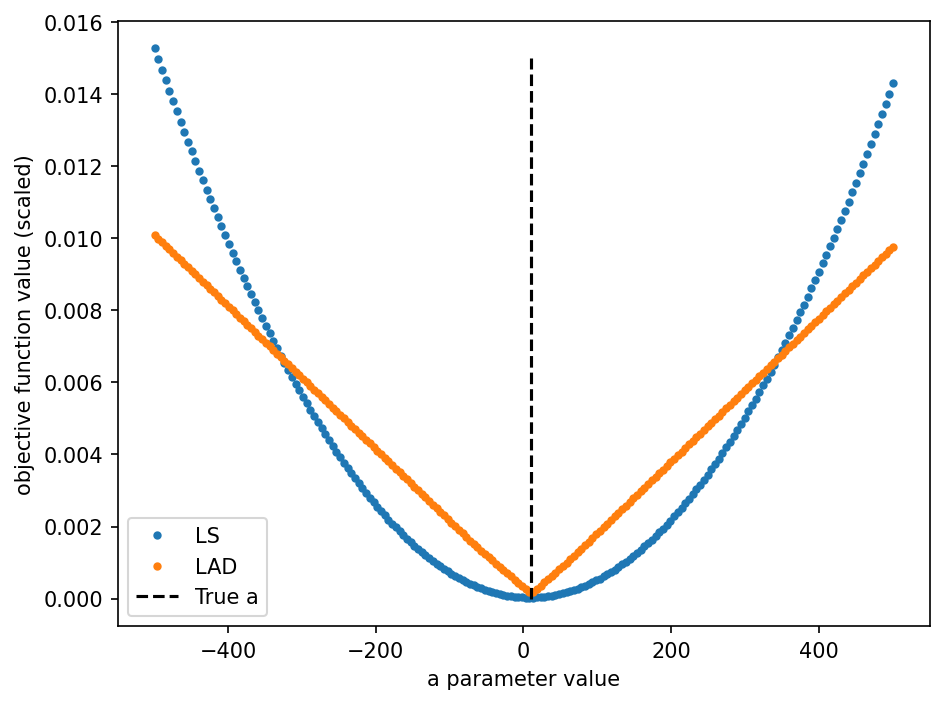

In [15]:
plt.figure(dpi=150)
plt.plot(a_variation, LS_OF/np.sum(LS_OF),".",label="LS")
plt.plot(a_variation, LAD_OF/np.sum(LAD_OF),".",label="LAD")
plt.plot([10,10], [0,0.0150],"k--", label="True a")
plt.legend()
plt.xlabel("a parameter value")
plt.ylabel("objective function value (scaled)")
plt.tight_layout()

# Experiment : 

    - change the number of data points. What happens ?
    - change the scale of the errors. What happens ?
    - include errors in the objective functions. What happens ?
    
What can you say, given your experiments, regarding the shift visible above from the true a value ?

# 2D Plot

We can also visualize things in a 2D+1 plot, the 2D being the values of the parameters, and the +1 being a third dimension that is the values of the misfit function. Let's do it!

In [16]:
b_variation = np.linspace(-20,20,num=200)

# and we calculate the objective function for each value, fixing b to it's true value.
LS_OF = np.zeros((200,200)) # we create a variable to store the least-square objective function values
LAD_OF = np.zeros((200,200)) # same for LAD
x_of = np.zeros((200,200)) #
y_of = np.zeros((200,200)) #
for i in range(len(a_variation)):
    for j in range(len(b_variation)):
        y_calculated = forward_model(x,a_variation[i],b_variation[j])
        LS_OF[i,j] = least_squares(y_observed,y_calculated)
        LAD_OF[i,j] = least_absolute_deviation(y_observed,y_calculated)
        
        x_of[i,:] = a_variation[i]
        y_of[:,j] = b_variation[j]


/tmp/ipykernel_199245/2843005529.py:5: UserWarning: linewidths is ignored by contourf
  curve = ax.contourf(x_of, y_of, LAD_OF, levels=14, linewidths=0.5)


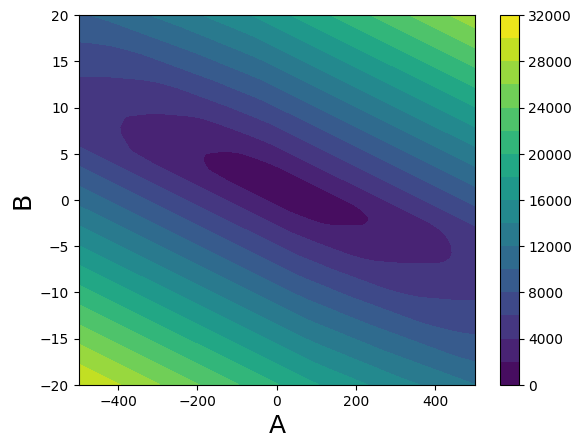

In [17]:
Xi, Yi = np.meshgrid(a_variation, b_variation)

fig = plt.figure()
ax = fig.add_subplot(111)
curve = ax.contourf(x_of, y_of, LAD_OF, levels=14, linewidths=0.5)

plt.xlabel("A",fontsize = 18)
plt.ylabel("B",fontsize = 18)
plt.colorbar(curve)